# Example 1 - How to use **Zernike**

In [1]:
import zern.zern_core as zern   # import the main library

# import logging
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.rc('font', family='sans-serif')

In [2]:
# Parameters
N = 1024      # Number of pixels
N_zern = 50
rho_max = 1.0
randgen = RandomState(12345)  # random seed

In [3]:
# [0] Construct the coordinates and the aperture mask - simple circ
x = np.linspace(-rho_max, rho_max, N)
xx, yy = np.meshgrid(x, x)
rho = np.sqrt(xx ** 2 + yy ** 2)
theta = np.arctan2(xx, yy)
aperture_mask = rho <= rho_max
rho, theta = rho[aperture_mask], theta[aperture_mask]

# [1] Basics - Calculating a Zernike wavefront
## [1.1] Initializing the Zernike class
The **Zernike** class needs to take the *masked* polar **coordinates** $\rho$ and $\theta$ to calculate the radial polynomials $R_{n,m}$ and the Zernike polynomials $Z_{n,m}$. It also needs to know what **mode** you want to use (we encourage the use of "Jacobi" for numerical stability and not "Standard"). To supress any verbose statements we use ``print_option=None``.

**Zernike** will calculate the maximum number $N_{zern}$ of Zernike polynomials needed based on the shape of the *coefficients* array you provide. 
NOTE: this will be *set* from then on, so choose 

In [4]:
z = zern.Zernike(mask=aperture_mask)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)


## [1.2] Using the **model_matrix** to calculate things faster

Once we have initialized the class and called it *once*, **Zernike** will store the *model_matrix* as a property, containing the basis of Zernike polynomials. This means we can speed up the calculation from now on by re-using that matrix and simply performing a *dot* product.

This is done through the *get_zernike* method. This will call the *z.model_matrix* of shape $(p, N_{zern})$, multiply it by the vector of coefficients *coef* of shape $(N_{zern},)$. After that, it will *invert* the flattened result $(p,)$ into a 2D array -> $(N, N)$.

To speed things up and avoid unnecessary calculations, **Zernike** operates on the *masked* or flattened array, i.e. only evaluating the points within the aperture mask. The ``get_zernike`` method already takes care of reconstructing the 2D array using the ``invert_mask`` function.

In [5]:
coef = randgen.normal(size=N_zern)
phase_map = z.get_zernike(coef)

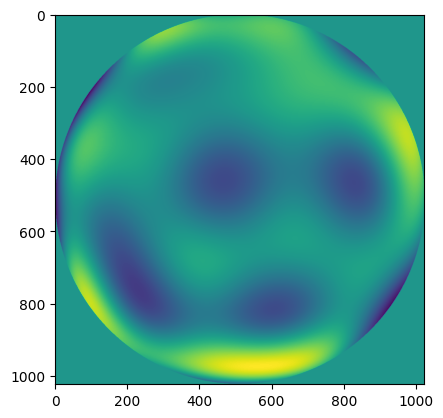

In [6]:
fig, ax = plt.subplots(1, 1)
ax.imshow(phase_map)
plt.show()
# z.N_total

## [1.3] Comparing both modes
xxx


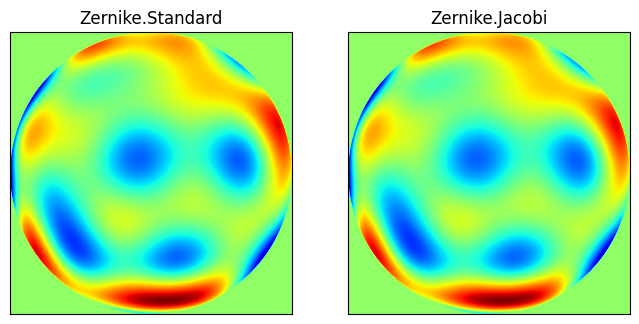

In [7]:
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Standard', normalize_noll=False)
map1 = z.get_zernike(coef)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)
map2 = z.get_zernike(coef)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cmap = 'jet'
ax1, ax2 = axes
ax1.imshow(map1, cmap=cmap)
ax2.imshow(map2, cmap=cmap)
ax1.set_title(r"Zernike.Standard")
ax2.set_title(r"Zernike.Jacobi")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# [2] Other topics
## [2.1] Evaluating specific Zernike polynomials $Z_{n,m}$

The **Zernike** class also supports evaluating specific Zernike polynomials based on their $n$ and $m$ orders.

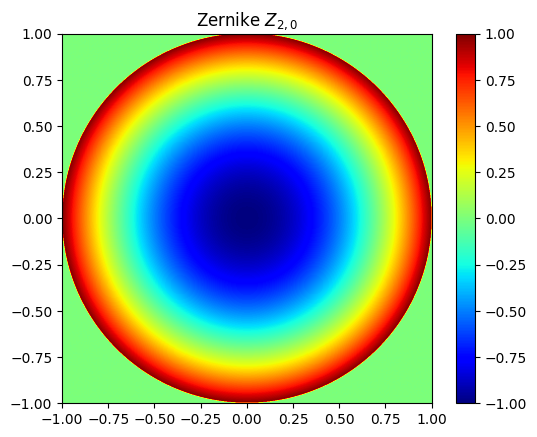

In [8]:
n, m = 2, 0
mode = "Jacobi"

z_flat = z.Z_nm(n, m, rho, theta, False, mode)
z_map = zern.invert_mask(z_flat, z.mask)       # Not that we need to unflatten the

fig, ax = plt.subplots(1, 1)
extents = [-rho_max, rho_max, -rho_max, rho_max]
img = ax.imshow(z_map, cmap='jet', extent=extents, vmin=-1, vmax=1)
ax.set_title(r"Zernike $Z_{%d, %d}$" % (n, m))

cbar = plt.colorbar(img)
# img.set_clim(v_min, v_max)
plt.show()

## [2.2] Normalization mode - Noll [same RMS]
By default the Zernike class calculates the Zernike polynomials for a Peak-to-Valley of $\pm1$. In other words, the maximum value of the polynomial $Z_{n,m}$ is always 1.0 and the minimum is 1.0. This means the RMS of the phase map varies with radial order. There is an option to rescale the polynomials using the Noll convention, such that the RMS of all wavefronts is 1.0

In [9]:
noll = True
z_noll = zern.Zernike(mask=aperture_mask)
z_noll.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=noll)

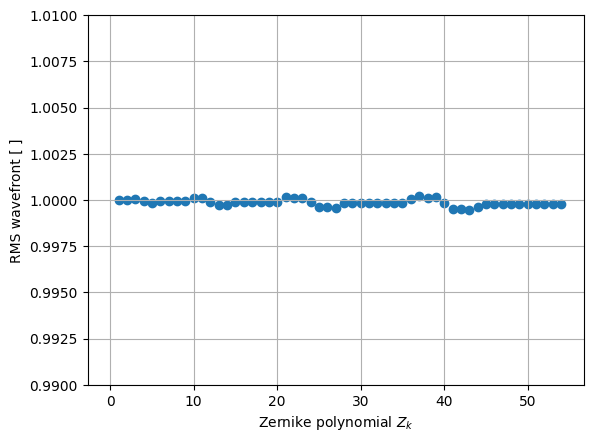

In [10]:
rms = [np.std(z_noll.model_matrix_flat[:, k]) for k in range(z.N_total)]

fig, ax = plt.subplots(1, 1)
ax.scatter(range(z.N_total), rms)
ax.set_ylim([0.99, 1.01])
ax.grid(True)
ax.set_xlabel("Zernike polynomial $Z_k$")
ax.set_ylabel("RMS wavefront [ ]")
plt.show()

## [2.3] Numerical stability

At high radial order, numerical issues start to build up closer to the edge of the aperture.
This can be shown by plotting the Zernike radial polynomial $Z_{n,m}(\rho)$ using the ``mode="Standard"``

In [11]:
r = np.linspace(0., 1., N)

z_stability = zern.Zernike(mask=aperture_mask)

Text(0, 0.5, 'Radial Zernike $Z_{n,m}(\\rho)$ []')

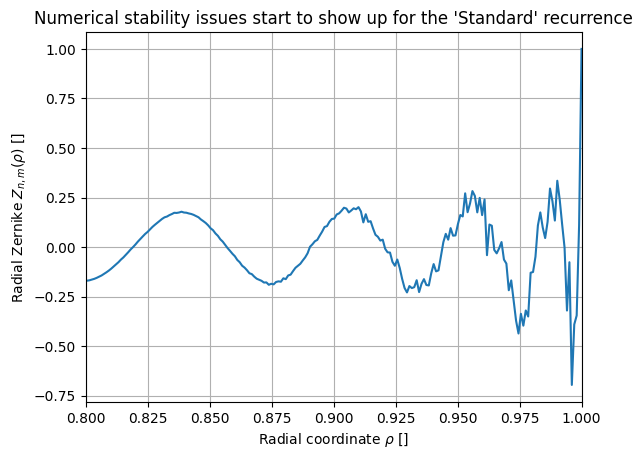

In [12]:
n = 44
m = 0

r_nm_std = z_stability.R_nm(n, m, r)   # Using 'Standard' recurrence

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_std)
ax.set_xlim([0.8, 1.0])
ax.grid(True)
ax.set_title("Numerical stability issues start to show up for the 'Standard' recurrence")
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")

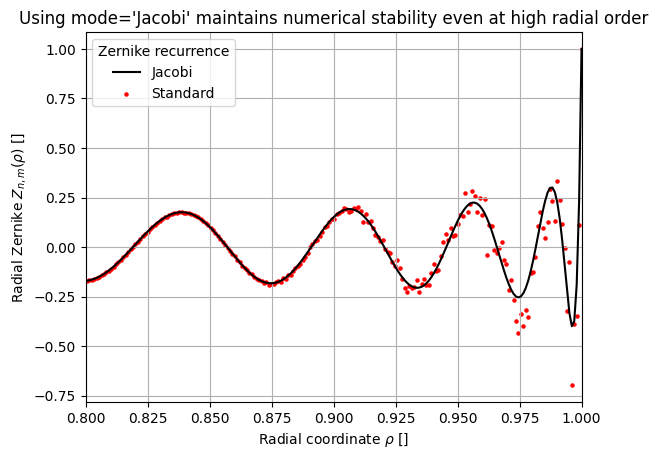

In [13]:
r_nm_std = z_stability.R_nm(n, m, r)
r_nm_jac = z_stability.R_nm_Jacobi(n, m, r)
err = r_nm_std - r_nm_jac

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_jac, label='Jacobi', c='k')
ax.scatter(r, r_nm_std, label='Standard', c='r', s=5)
ax.set_xlim([0.8, 1.0])
ax.legend(loc=2, title='Zernike recurrence')
ax.set_title("Using mode='Jacobi' maintains numerical stability even at high radial order")
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")
ax.grid(True)

## [2.3] Fitting a wavefront to Zernike polynomials

Another functionality of **Zernike** is to

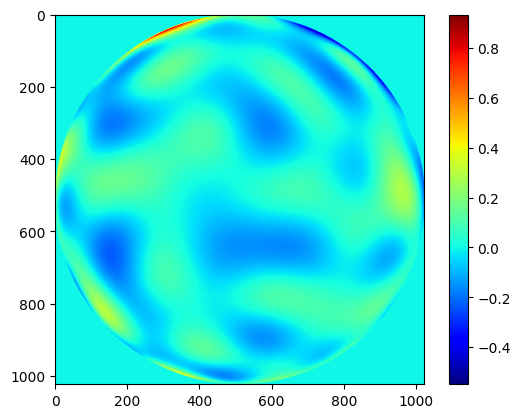

In [14]:
N_zern = 100
coef = randgen.normal(size=N_zern) / N_zern

z_ls = zern.Zernike(mask=aperture_mask)
z_ls.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=True)

phase_map = z_ls.get_zernike(coef)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(phase_map, cmap='jet')
plt.colorbar(img)
plt.show()

Add two separate maps together and then fit.

In [15]:
flat_phase_map = phase_map[z_ls.mask]

from scipy.optimize import least_squares
coef_guess = np.zeros(z_ls.N_total)
result_ls = least_squares(fun=zern.least_squares_zernike, x0=coef_guess,
                        args=(flat_phase_map, z_ls))

In [22]:
flat_phase_map = phase_map[z_ls.mask]
H_f = z_ls.model_matrix_flat


In [31]:
# H_f.T.shape
y = np.dot(H_f.T, flat_phase_map)
N = np.dot(H_f.T, H_f)
invN = np.linalg.inv(N)
res = np.dot(invN, y)

In [32]:
res

array([ 6.98766888e-04,  2.46674110e-03, -1.18616011e-04,  1.00481159e-02,
        1.32719461e-02, -9.19261558e-03, -1.54910644e-02,  2.21845987e-04,
        7.58363145e-03, -6.60524328e-03,  8.62580083e-03, -1.00319021e-04,
        5.00093559e-04,  6.70215594e-03,  8.52965032e-03, -9.55868852e-03,
       -2.34933207e-04, -2.30423388e-02, -6.52468841e-03, -1.21830198e-02,
       -1.33260971e-02,  1.07462269e-02,  7.23641505e-03,  6.90001853e-03,
        1.00154344e-02, -5.03087391e-03, -6.22274225e-03, -9.21168608e-03,
       -7.26213493e-03,  2.22895546e-03,  5.13161009e-04, -1.15771947e-02,
        8.16706936e-03,  4.33609606e-03,  1.01073695e-02,  1.82487521e-02,
       -9.97518248e-03,  8.50591099e-03, -1.31577601e-03,  9.12414152e-03,
        1.88210680e-03,  2.16946144e-02, -1.14928205e-03,  2.00369736e-02,
        2.96101523e-04,  7.95253156e-03,  1.18109754e-03, -7.48531548e-03,
        5.84969738e-03,  1.52676573e-03, -1.56565729e-02, -5.62540188e-03,
       -3.26641392e-04, -

In [18]:
result_ls['x']

array([ 6.98766888e-04,  2.46674110e-03, -1.18616011e-04,  1.00481159e-02,
        1.32719461e-02, -9.19261558e-03, -1.54910644e-02,  2.21845987e-04,
        7.58363145e-03, -6.60524328e-03,  8.62580083e-03, -1.00319021e-04,
        5.00093559e-04,  6.70215594e-03,  8.52965032e-03, -9.55868852e-03,
       -2.34933207e-04, -2.30423388e-02, -6.52468841e-03, -1.21830198e-02,
       -1.33260971e-02,  1.07462269e-02,  7.23641505e-03,  6.90001853e-03,
        1.00154344e-02, -5.03087391e-03, -6.22274225e-03, -9.21168608e-03,
       -7.26213493e-03,  2.22895546e-03,  5.13161009e-04, -1.15771947e-02,
        8.16706936e-03,  4.33609606e-03,  1.01073695e-02,  1.82487521e-02,
       -9.97518248e-03,  8.50591099e-03, -1.31577601e-03,  9.12414152e-03,
        1.88210680e-03,  2.16946144e-02, -1.14928205e-03,  2.00369736e-02,
        2.96101523e-04,  7.95253156e-03,  1.18109754e-03, -7.48531548e-03,
        5.84969738e-03,  1.52676573e-03, -1.56565729e-02, -5.62540188e-03,
       -3.26641392e-04, -

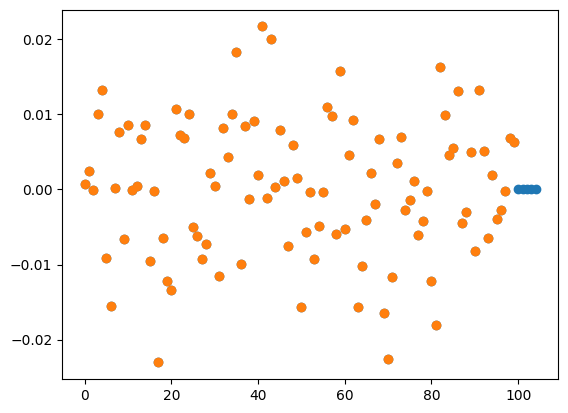

In [21]:
fig, ax = plt.subplots(1, 1)
ax.scatter(range(z_ls.N_total), result_ls['x'])
ax.scatter(range(coef.shape[0]), coef)